<a href="https://colab.research.google.com/github/jerovernay/tp-Alc/blob/main/codigo/TP1_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

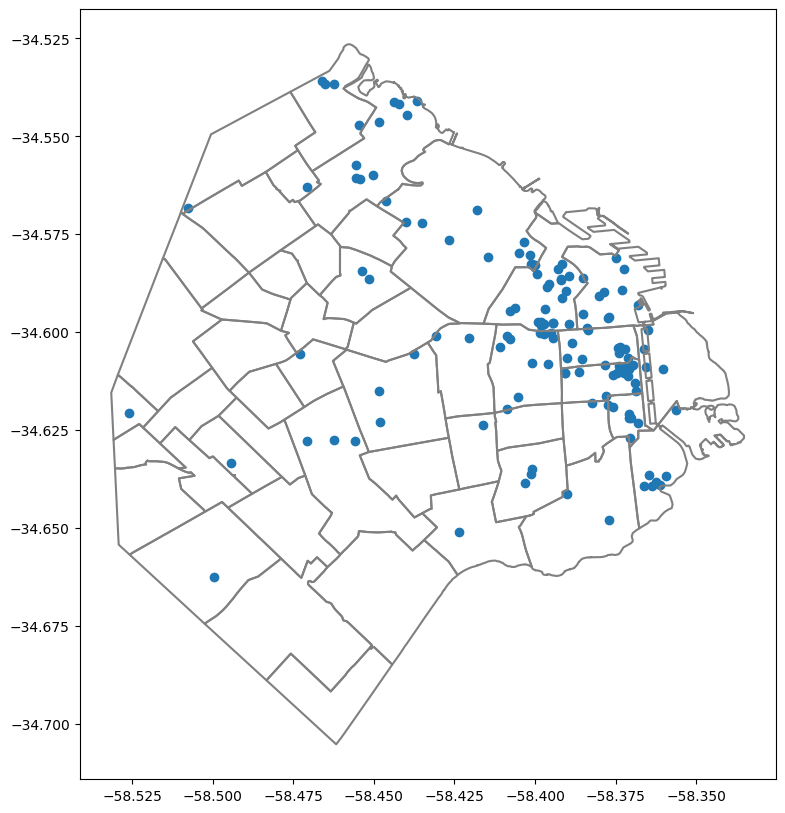

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

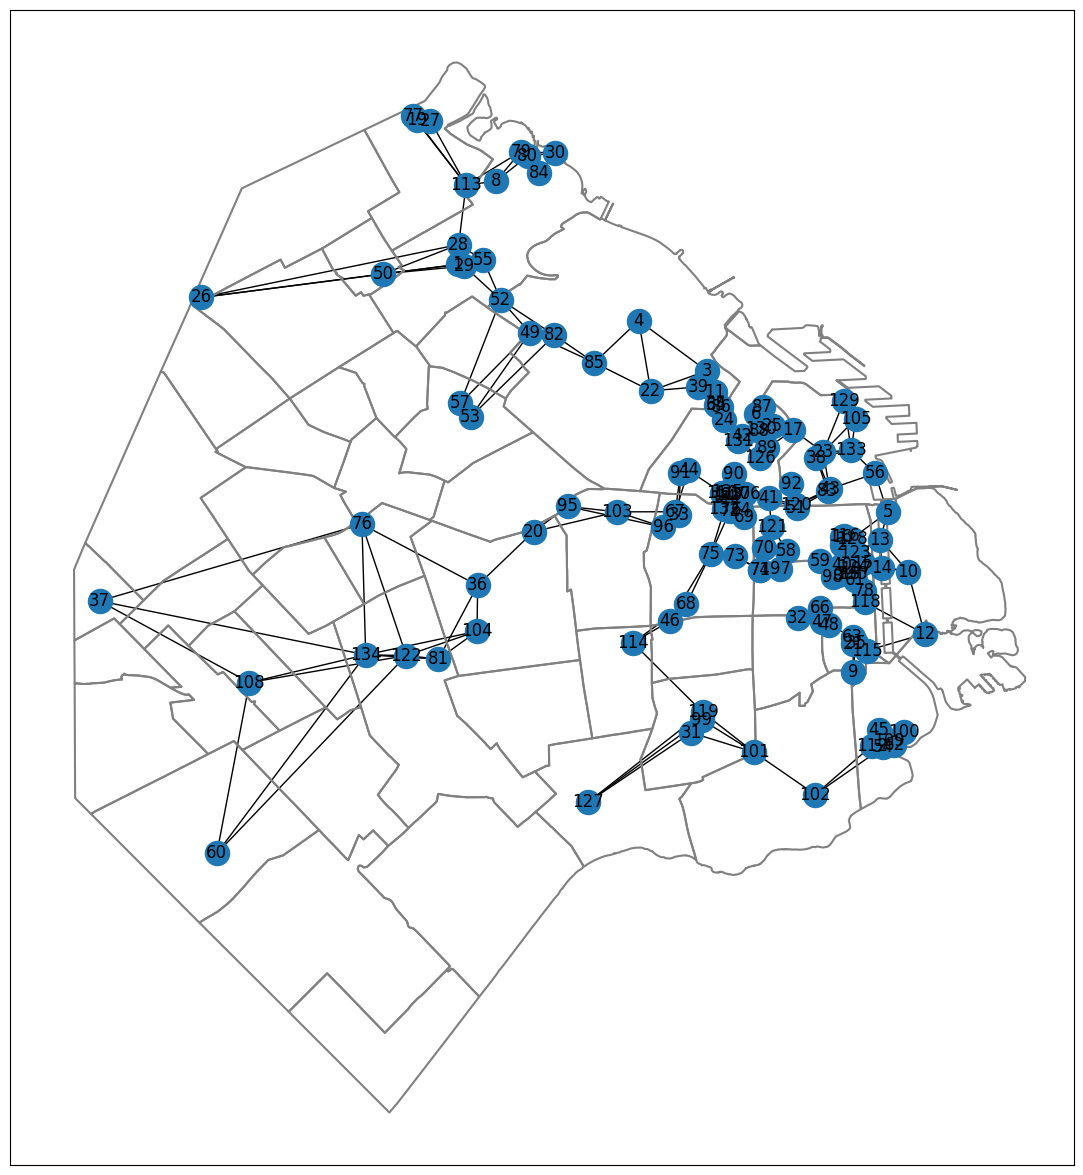

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

##Resolucion

Tenemos que probar la igualdad:

$$
M ⋅ p = B
$$

donde:

$$
M = \frac{N}{\alpha} \left( I - (1 - \alpha) \; C \right) \quad \text {y } \, B = 1 \\[12pt]
$$


A partir de los datos dados vamos a manipular algebraicamente esta ecuación para llegar a la forma:

&nbsp;


$$
M ⋅ p = B \quad \text {tal que} \quad M ⋅ p = 1 \\[12pt]
$$

Partimos de la ecuacion (3):

&nbsp;

$$
p = (1 - \alpha)\, C ⋅ p \, + \, \frac {α}{N} \cdot 1 \\[12pt]
$$

Reordeno la ecuacion (3) para que me queden juntos los valores de $p$:

&nbsp;

$$
p - (1 - \alpha)\, C p \, = \, \frac {α}{N} \\[12pt]
$$

$$ \left( I - (1 - \alpha) \; C \right) \; \cdot \; p \; = \; \frac {α}{N} \\[12pt] $$

$$ \frac {N}{\alpha} \; \left( I - (1 - \alpha) \; C \right) \; \cdot \; p \; = \; 1 \\[12pt] $$

$$ M \; \cdot \; p \; = \; 1 \\[8pt]$$

#### De esta manera probamos que el vector de rankings $p$ es solucion de la ecuacion

## Punto 2:


##Resolucion

Para que exista una unica solucion para el sitema de ecuaciones $M ⋅ p = b$ donde:

&nbsp;

$$ M = \frac{N}{\alpha} \left( I - (1 - \alpha) \; C \, \right) \quad \text {y } \, B = 1 \\[12pt] $$

Necesitamos que la matriz $M$ sea inversible:

&nbsp;

$$ M \, ⋅ \, p \; = \; B \quad ⟹ \quad p \; = \; (M)^{-1} \; \cdot \; B \\[8pt]$$

$$ \exists\, M^{-1} \;\Rightarrow\; \exists!\, p \\[10pt] $$

Si existe la inversa de $M$ existe una unica solucion $p$

&nbsp;

El enunciado nos brinda que $0 < α < 1$ , por lo tanto, esto nos permite ver que la inversibilidad de la matriz depende exlclusivamente de $(I - (1 - α) \, C)$ tal que:

&nbsp;

$$ M^{-1} \; = \left( \; \frac{N}{\alpha} \left( I - (1 - \alpha) \; C \, \right) \, \right)^{-1} \\[10pt] $$

$$ M^{-1} \; = \; \frac{α}{N} \, \left( I - (1 - \alpha) \; C \, \right)^{-1} \\[8pt] $$

$$ \; \frac{α}{N} \neq 0 \; \text{ya que} \; \alpha \in (0,1) \\[12pt]$$

De esta forma vemos que $\frac{α}{N}$ es solamente un factor escalar de $M$

##Esto esta mal desde aca


Por lo tanto, veamos si es posible encontrar algun valor de $(0,1)$ que impliquen que $M$ no sea inversible:

&nbsp;

$$ (\, I \, - \, (\,1\, - α\,) \, C \,) \neq 0 \\[8pt]$$
$$ I \; \neq \; (\,1\, - α\,) \, C \; \; \rightarrow \; (\, 1 \,- \, \alpha \,) \; \neq 1 \quad \text {;}\quad  \alpha \, \in \, (0,1) \\[8pt]$$

Demostramos que siempre $\exists \; M^{-1} \;$ tal que exista una unica solucion de $p$

## Punto 3:

In [13]:
from scipy.linalg import lu, solve_triangular

def inversa_por_lu(A):
    n = A.shape[0]

    # Realizamos la factorización LU de la matriz A
    P, L, U = lu(A)

    # Inicializamos la matriz identidad I
    I = np.eye(n)
    A_inv = np.zeros_like(A, dtype=float)

    # Resolvemos para cada columna de la matriz inversa
    for i in range(n):

        b = I[:, i]  # La columna i de la identidad

        # Resolvemos L y U
        y = solve_triangular(L, P @ b, lower=True)

        x = solve_triangular(U, y)

        A_inv[:, i] = x  # Guardamos el resultado en la columna i de A_inv

    return A_inv


# Primero creo K a partir de la matriz A

def crearK (A):

    n = A.shape[0]
    m = A.shape[1]
    K = np.zeros((m, n))
    sumaFilasA = np.sum(A, axis = 1)

    if m!=n:
        print('Estamos trabajando con una matriz no cuadrada')
        return

    for i in range (len (sumaFilasA)):
        K[i, i] = sumaFilasA[i]

    return K


def matriz_Transicion1 (A):
    A_traspuesta = np.transpose(A)
    K = crearK(A)
    K_inversa = inversa_por_lu(K)
    C = A_traspuesta @ K_inversa

    return C

# Calculo del PageRank

def calculo_Page_Rank(A, alpha, N):
    n = A.shape[0]

    # Genero la matriz de transicion en base a A y una identidad en base a n de A
    C = matriz_Transicion1(A)
    I = np.eye(n)

    # Genero b = 1 y hago la cuenta de P

    M = (N/alpha) * ( I - (1-alpha) * C )
    b = np.ones(n)

    P = inversa_por_lu(M) @ b

    return P

In [22]:
print(calculo_Page_Rank(A,0.2, 3))

[0.16152125 0.65329916 0.41832676 0.1951924  0.13947448 0.15219143
 0.65617309 0.27918345 0.12371839 0.06666667 0.12072297 0.52440965
 0.06666667 0.13944384 0.13604448 0.17529736 0.41832676 0.11721157
 0.96473209 0.14285714 0.19897709 0.49528158 0.17666767 0.25272452
 0.26915689 0.54270751 0.06666667 0.14285714 0.69833999 0.68409926
 0.46284371 0.46232247 0.20547945 0.41769274 0.63975493 0.49528158
 0.29882374 0.09601276 0.18316287 0.16582935 0.16152125 0.39173992
 0.09855558 0.24731736 0.16216645 0.32834308 0.14285714 0.26027397
 0.26027397 0.2321059  0.08444444 0.29608984 0.21296715 0.09090909
 0.48987471 0.66632148 0.18127403 0.09090909 0.21883245 0.06666667
 0.06666667 0.37887805 0.37827344 0.53604102 0.15961846 0.71575951
 0.26027397 0.51310656 0.14285714 0.10923159 0.40059944 0.40078348
 0.23933763 0.11278195 0.40078348 0.17293233 0.09227007 0.14285714
 0.09601276 0.53393052 0.48888969 0.57934185 0.22561181 0.16925054
 0.46284371 0.2730293  0.63975493 0.24164616 0.69847486 0.1245

#Esto esta horriblemente mal

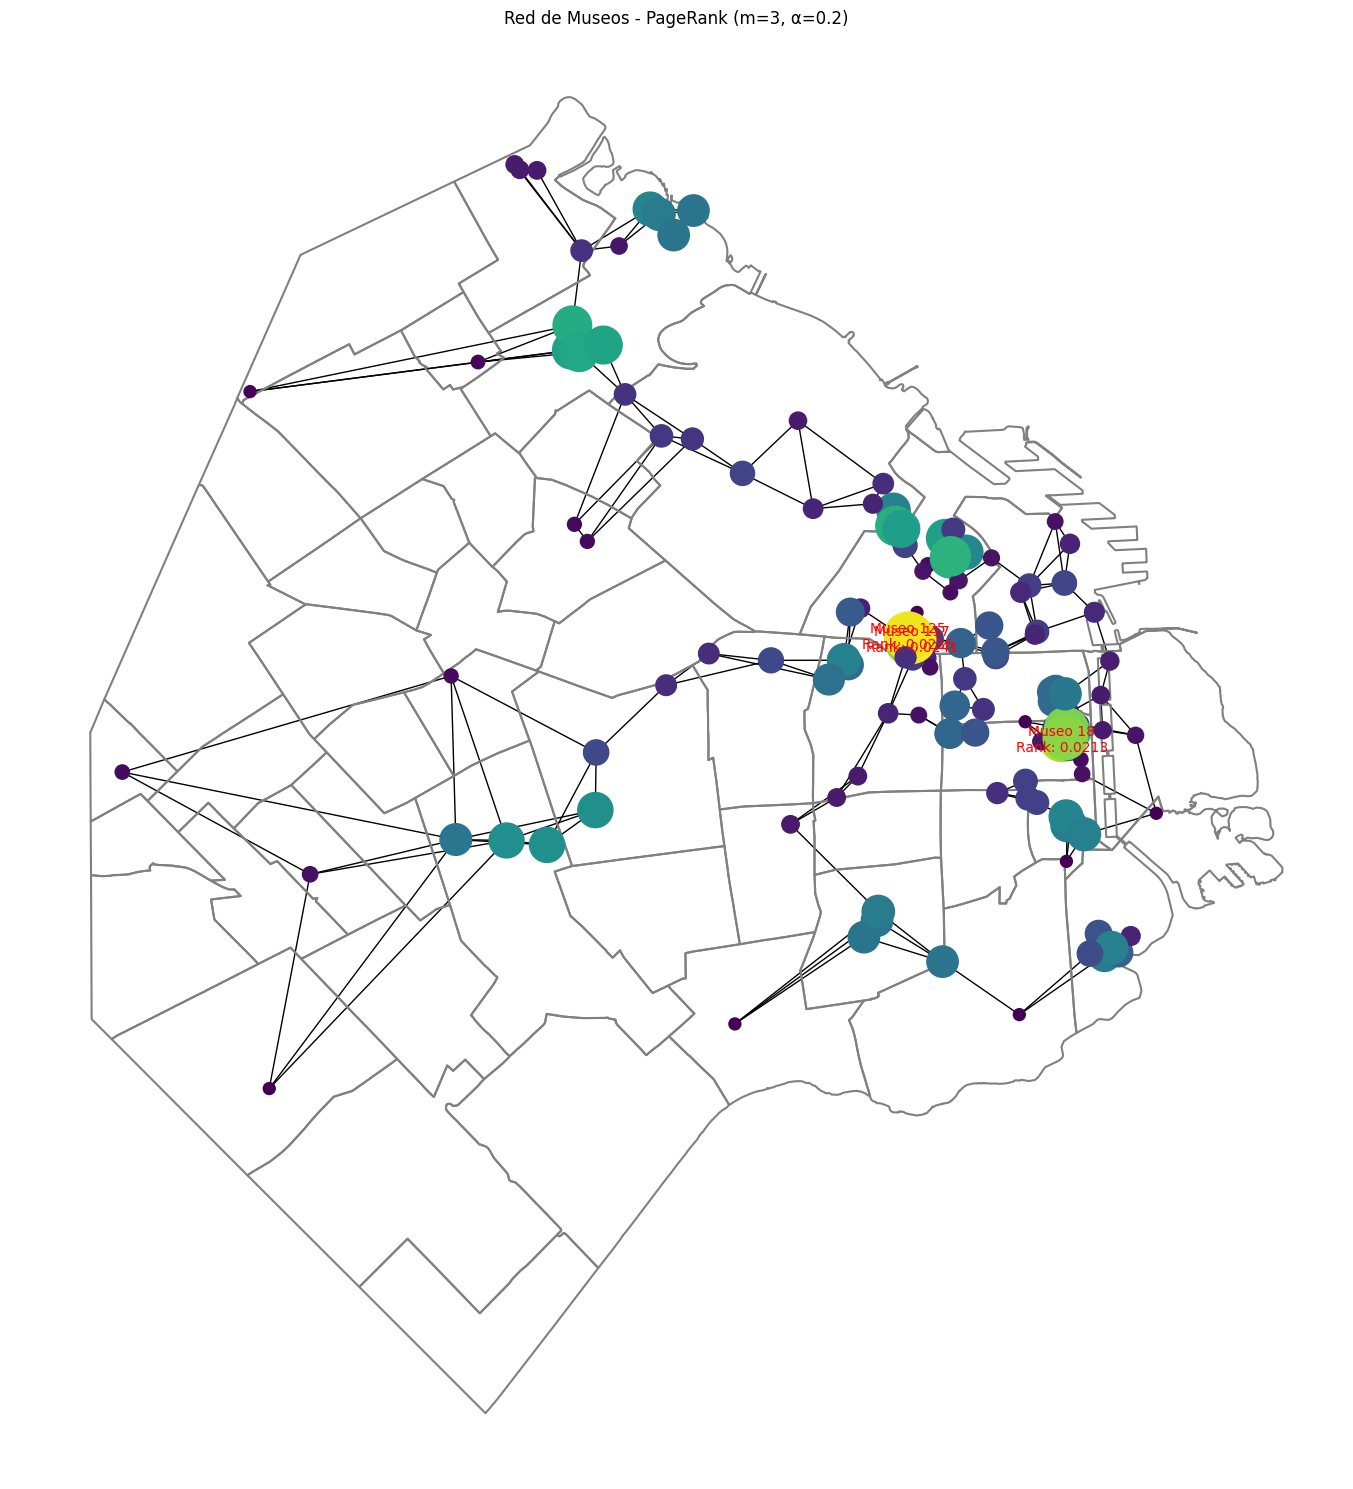

Los 3 museos con mayor PageRank son:
1. Museo 117: PageRank = 0.024135
2. Museo 125: PageRank = 0.023529
3. Museo 18: PageRank = 0.021281


In [20]:
# Calcular PageRank para m=3 y alpha=1/5
m = 3
alpha = 1/5
N = museos.shape[0]  # número de museos

# Construir matriz de adyacencia
A = construye_adyacencia(D, m)

# Calcular PageRank
page_rank = calculo_Page_Rank(A, alpha, N)

#Normalizo
page_rank = page_rank / np.sum(page_rank)


# Visualizar la red con tamaños proporcionales al PageRank
factor_escala = 5e4  # Ajustar este valor según sea necesario para visualización

# Crear el grafo
G = nx.from_numpy_array(A)
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],
                                          museos.to_crs("EPSG:22184").get_coordinates()['y']))}

# Identificar los 3 museos con mayor PageRank
N_principales = 3
principales = np.argsort(page_rank)[-N_principales:]

# Crear figura y graficar
fig, ax = plt.subplots(figsize=(15, 15))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)

# Etiquetar solo los N principales museos
labels = {n: f"Museo {n}\nRank: {page_rank[i]:.4f}" if i in principales else ""
          for i, n in enumerate(G.nodes)}

# Dibujar la red
nx.draw_networkx(G, G_layout,
                 node_size=page_rank*factor_escala,  # Tamaño proporcional al PageRank
                 node_color=page_rank,  # Color según PageRank
                 cmap=plt.cm.viridis,  # Usar un mapa de colores
                 with_labels=False,
                 ax=ax)

# Agregar etiquetas solo para los principales
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=10, font_color="red")

# Añadir título y leyenda
plt.title(f'Red de Museos - PageRank (m={m}, α={alpha})')
plt.axis('off')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir información sobre los 3 museos principales
print("Los 3 museos con mayor PageRank son:")
for i, idx in enumerate(principales[::-1]):  # Invertir para mostrar en orden descendente
    print(f"{i+1}. Museo {idx}: PageRank = {page_rank[idx]:.6f}")

Índices de los museos con mayor PageRank: [ 18 125 117]
Valores de PageRank correspondientes: [0.02128085 0.0235294  0.02413501]


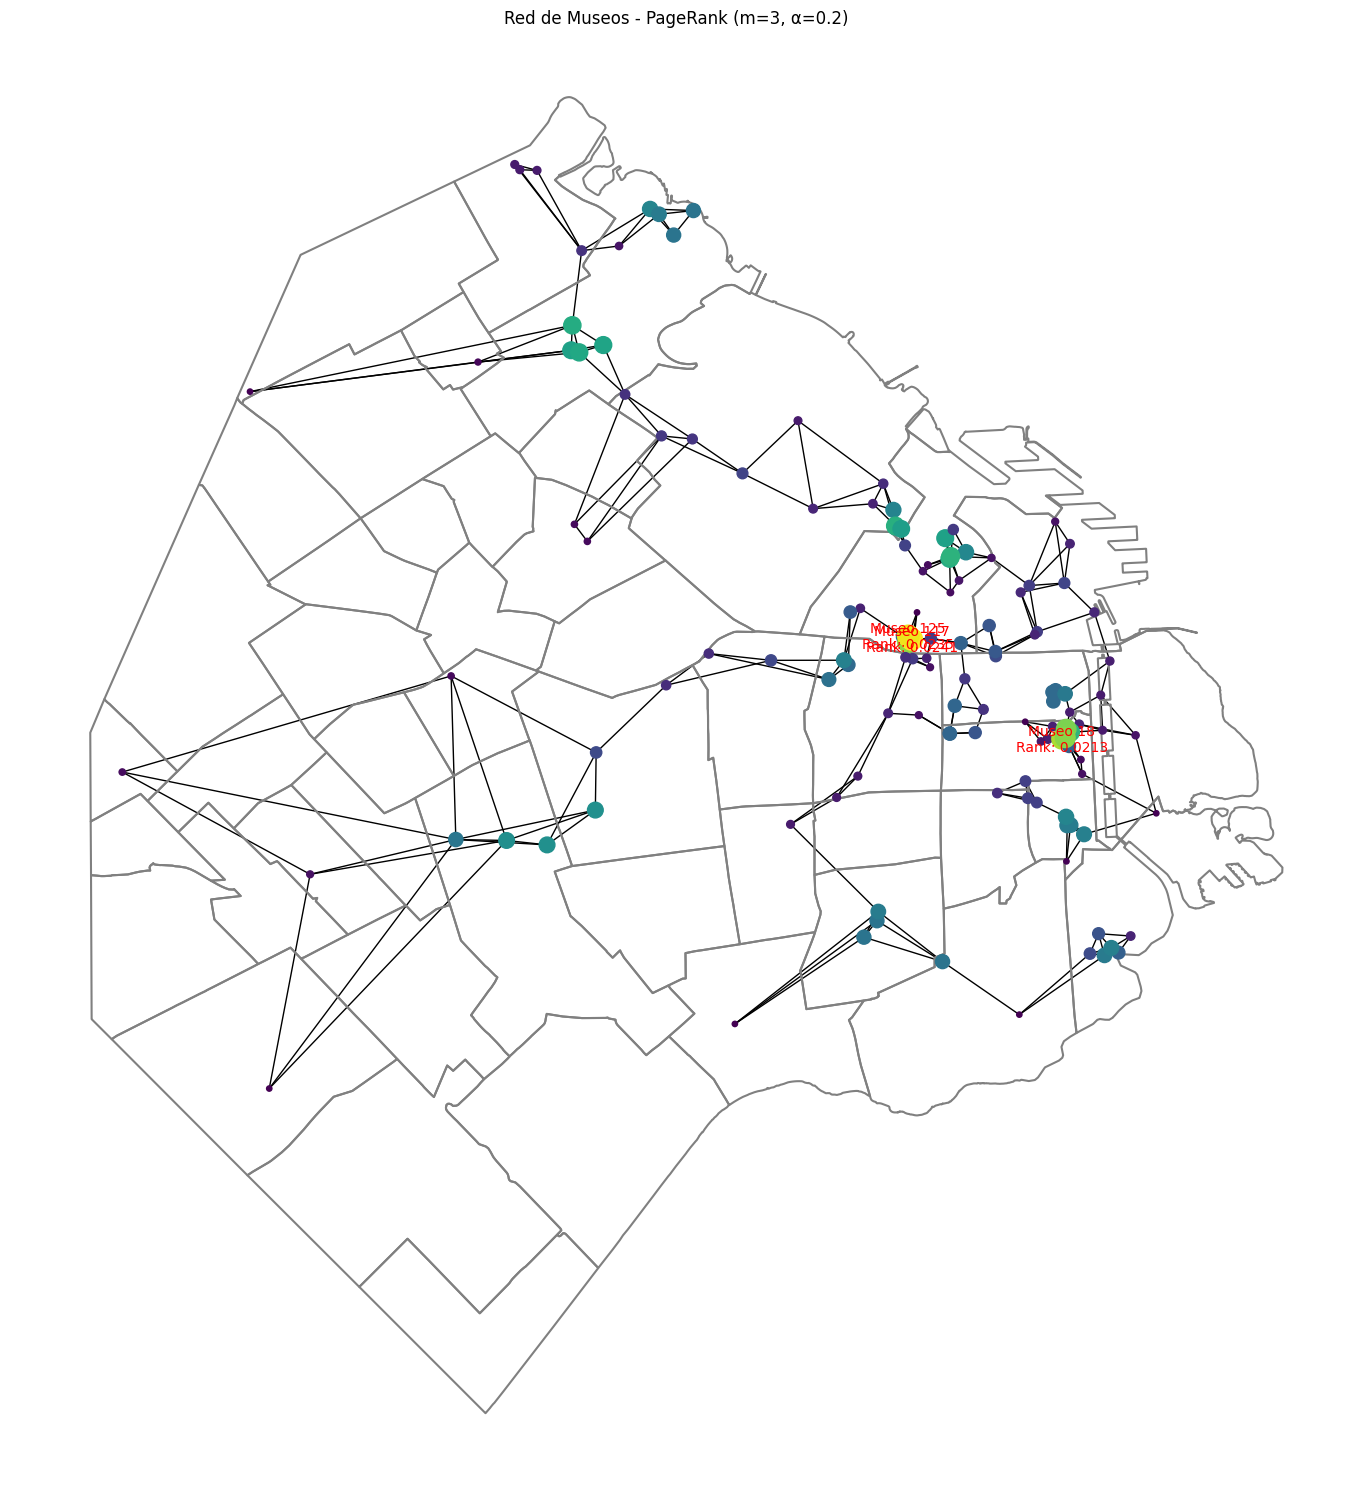

Los 3 museos con mayor PageRank son:
1. Museo 117: PageRank = 0.024135
2. Museo 125: PageRank = 0.023529
3. Museo 18: PageRank = 0.021281


In [19]:
# Calcular PageRank para m=3 y alpha=1/5
m = 3
alpha = 1/5
N = museos.shape[0]  # número de museos

# Construir matriz de adyacencia
A = construye_adyacencia(D, m)

# Calcular PageRank
page_rank = calculo_Page_Rank(A, alpha, N)

# Crear el grafo
G = nx.from_numpy_array(A)
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],
                                          museos.to_crs("EPSG:22184").get_coordinates()['y']))}

# Identificar los 3 museos con mayor PageRank
N_principales = 3
principales = np.argsort(page_rank)[-N_principales:]

# Verificar cuáles son los índices y valores más altos
print("Índices de los museos con mayor PageRank:", principales)
print("Valores de PageRank correspondientes:", page_rank[principales])

# Crear figura y graficar
fig, ax = plt.subplots(figsize=(15, 15))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)

# Factor de escala ajustado para visualizar mejor
factor_escala = 1e4

# Etiquetar solo los N principales museos
labels = {n: f"Museo {n}\nRank: {page_rank[i]:.4f}" if i in principales else ""
          for i, n in enumerate(G.nodes)}

# Dibujar la red
nx.draw_networkx(G, G_layout,
                 node_size=page_rank*factor_escala,  # Tamaño proporcional al PageRank
                 node_color=page_rank,  # Color según PageRank
                 cmap=plt.cm.viridis,  # Usar un mapa de colores
                 with_labels=False,
                 ax=ax)

# Agregar etiquetas solo para los principales
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=10, font_color="red")

# Añadir título y leyenda
plt.title(f'Red de Museos - PageRank (m={m}, α={alpha})')
plt.axis('off')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir información sobre los 3 museos principales
print("Los 3 museos con mayor PageRank son:")
for i, idx in enumerate(principales[::-1]):  # Invertir para mostrar en orden descendente
    print(f"{i+1}. Museo {idx}: PageRank = {page_rank[idx]:.6f}")

## Punto 4:

## Punto 5:

## Punto 6:

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, '6'),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19

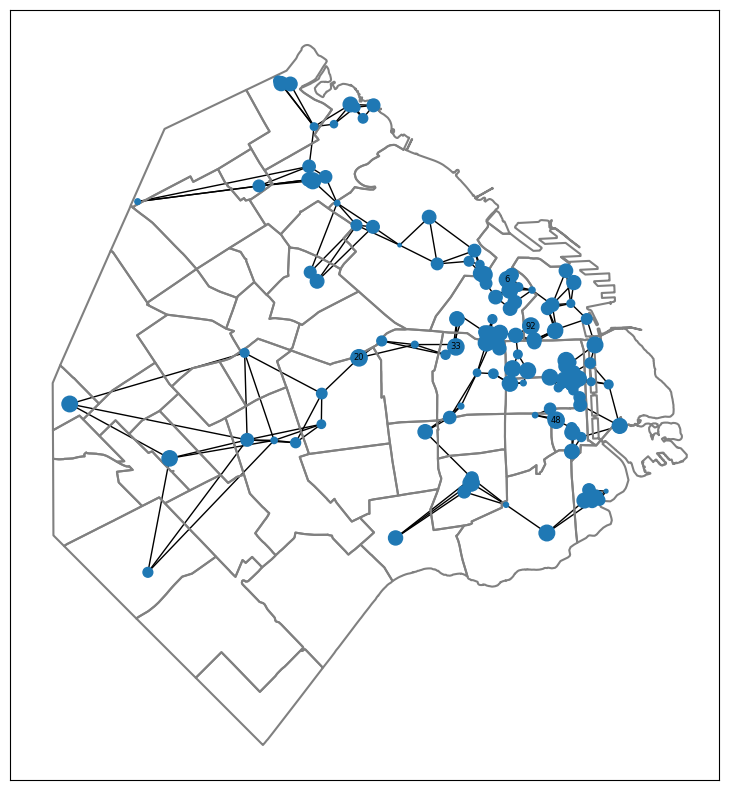

In [8]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres